In [2]:
!git clone https://github.com/vamsi3/simple-GAN.git
!cd simple-GAN/assets/PyTorch

Cloning into 'simple-GAN'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (25/25), 1.89 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [1]:
import torch
print("GPU is available:", torch.cuda.is_available())
print("Current Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")




GPU is available: True
Current Device: Tesla T4


In [2]:
# Check if GPU is available
import torch
print("GPU is available:", torch.cuda.is_available())

# Install any necessary libraries (most are pre-installed)
!pip install matplotlib torchvision


GPU is available: True


In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Transformations for preprocessing the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the MNIST dataset
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.46MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
loss_fn = nn.BCELoss()


In [8]:
num_epochs = 50

for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        # Train Discriminator
        real_images = real_images.view(-1, 784).to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_images = generator(torch.randn(real_images.size(0), 100).to(device))
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        d_loss_real = loss_fn(discriminator(real_images), real_labels)
        d_loss_fake = loss_fn(discriminator(fake_images.detach()), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        fake_images = generator(torch.randn(real_images.size(0), 100).to(device))
        g_loss = loss_fn(discriminator(fake_images), real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch [1/50], D Loss: 0.922528862953186, G Loss: 2.737795829772949
Epoch [2/50], D Loss: 0.14119920134544373, G Loss: 4.5119428634643555
Epoch [3/50], D Loss: 0.36635297536849976, G Loss: 3.7664389610290527
Epoch [4/50], D Loss: 0.4806883633136749, G Loss: 2.53059983253479
Epoch [5/50], D Loss: 0.20319817960262299, G Loss: 2.370898962020874
Epoch [6/50], D Loss: 0.37499427795410156, G Loss: 2.951267719268799
Epoch [7/50], D Loss: 0.7392592430114746, G Loss: 3.359867572784424
Epoch [8/50], D Loss: 0.7777453660964966, G Loss: 3.108527183532715
Epoch [9/50], D Loss: 0.30860960483551025, G Loss: 2.4104232788085938
Epoch [10/50], D Loss: 0.5076311826705933, G Loss: 2.9756550788879395
Epoch [11/50], D Loss: 0.2683993875980377, G Loss: 2.7218055725097656
Epoch [12/50], D Loss: 0.6694381833076477, G Loss: 2.3137824535369873
Epoch [13/50], D Loss: 0.26533159613609314, G Loss: 3.895789623260498
Epoch [14/50], D Loss: 0.6937074661254883, G Loss: 2.9300711154937744
Epoch [15/50], D Loss: 0.8584160

In [9]:
def generate_and_save_images(epoch, generator):
    noise = torch.randn(16, 100).to(device)
    generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
    grid = np.transpose(torchvision.utils.make_grid(generated_images, nrow=4, normalize=True), (1, 2, 0))
    plt.imshow(grid)
    plt.title(f"Epoch {epoch}")
    plt.show()

# Call this function after each epoch
generate_and_save_images(epoch, generator)


NameError: name 'torchvision' is not defined

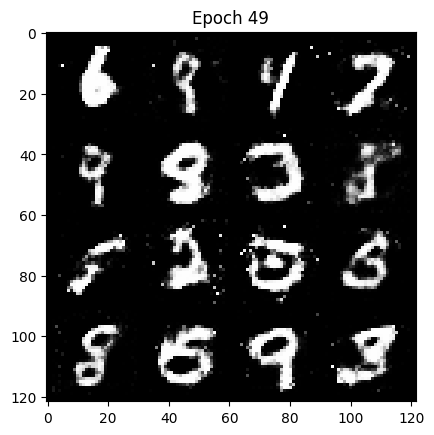

In [10]:
def generate_and_save_images(epoch, generator):
    noise = torch.randn(16, 100).to(device)
    generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()

    # Import torchvision.utils here
    import torchvision.utils

    grid = np.transpose(torchvision.utils.make_grid(generated_images, nrow=4, normalize=True), (1, 2, 0))
    plt.imshow(grid)
    plt.title(f"Epoch {epoch}")
    plt.show()

# Call this function after each epoch
generate_and_save_images(epoch, generator)

In [11]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


In [12]:
# Load generator
generator.load_state_dict(torch.load("generator.pth"))
generator.eval()

# Generate images
noise = torch.randn(16, 100).to(device)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
plt.figure(figsize=(8, 8))
grid = np.transpose(torchvision.utils.make_grid(generated_images, nrow=4, normalize=True), (1, 2, 0))
plt.imshow(grid)
plt.show()


<ipython-input-12-dc5848c598b2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))


NameError: name 'torchvision' is not defined

<Figure size 800x800 with 0 Axes>

<ipython-input-13-afc1e38b3e8c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))


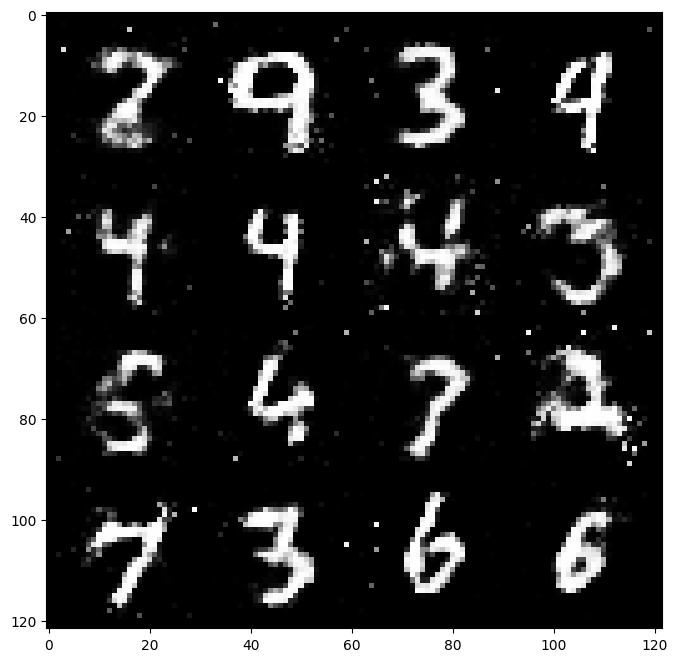

In [13]:
# Load generator
generator.load_state_dict(torch.load("generator.pth"))
generator.eval()

# Generate images
noise = torch.randn(16, 100).to(device)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
plt.figure(figsize=(8, 8))

# Import torchvision.utils
import torchvision.utils

grid = np.transpose(torchvision.utils.make_grid(generated_images, nrow=4, normalize=True), (1, 2, 0))
plt.imshow(grid)
plt.show()